In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
import imageio

%matplotlib inline

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [3]:
train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0

In [4]:
train_x.shape

(60000, 28, 28, 1)

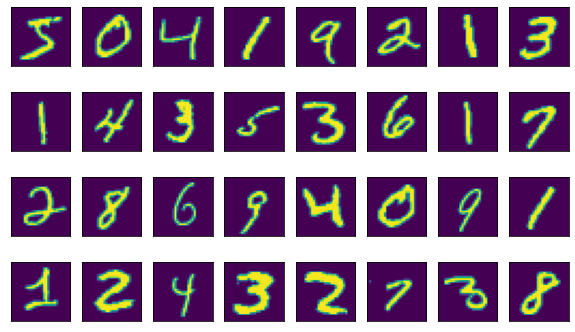

In [5]:
some_samples = train_x[:32, ...]
fig = plt.figure(figsize=(10, 6))
for i in range(some_samples.shape[0]):
    ax  = fig.add_subplot(4,8,i+1)
    ax.imshow(some_samples[i,:,:,0])
    plt.xticks([]), plt.yticks([])

In [6]:
model = kr.models.Sequential([
    kr.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    kr.layers.MaxPool2D((2,2), (2,2)),
    kr.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    kr.layers.MaxPool2D((2,2), (2,2)),
    kr.layers.Flatten(),
    kr.layers.Dense(256, activation='relu'),
    kr.layers.Dense(10, activation='softmax')
])

In [7]:
model.compile(optimizer='sgd',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [9]:
NUM_EPOCHS = 10

In [10]:
%%time

model.fit(train_x, train_y, epochs=NUM_EPOCHS)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 57s 953us/sample - loss: 0.4279 - accuracy: 0.8756
Epoch 2/10
60000/60000 [==============================] - 53s 889us/sample - loss: 0.1105 - accuracy: 0.9672
Epoch 3/10
60000/60000 [==============================] - 56s 940us/sample - loss: 0.0762 - accuracy: 0.9774
Epoch 4/10
60000/60000 [==============================] - 54s 906us/sample - loss: 0.0605 - accuracy: 0.9811
Epoch 5/10
60000/60000 [==============================] - 55s 919us/sample - loss: 0.0509 - accuracy: 0.9847
Epoch 6/10
60000/60000 [==============================] - 58s 975us/sample - loss: 0.0438 - accuracy: 0.9863
Epoch 7/10
60000/60000 [==============================] - 56s 941us/sample - loss: 0.0385 - accuracy: 0.9883
Epoch 8/10
60000/60000 [==============================] - 52s 869us/sample - loss: 0.0345 - accuracy: 0.9895
Epoch 9/10
60000/60000 [==============================] - 52s 862us/sample - loss: 0.0311 - accuracy: 0.9

In [11]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 2s 211us/sample - loss: 0.0315 - accuracy: 0.9889


[0.03148771539422451, 0.9889]

In [21]:
sample = test_x[0, ...]
prediction = model(sample[None, ...])[0]
print(prediction)

tf.Tensor(
[9.0669133e-08 2.6186726e-08 1.5653992e-05 9.7675838e-06 1.2210462e-10
 7.7297351e-08 4.8087507e-14 9.9997175e-01 6.1852560e-08 2.4628253e-06], shape=(10,), dtype=float32)


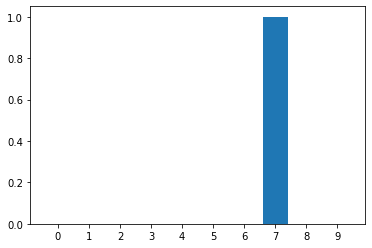

In [31]:
plt.bar(list(range(10)), prediction)
plt.xticks(list(range(10)));

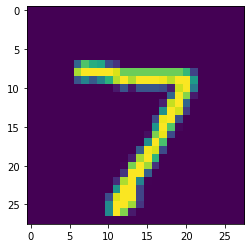

In [39]:
plt.imshow(sample[:,:,0]);

In [15]:
def test_digit(sample):
    prediction = model(sample[None,...])[0]
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(sample[:,:,0])
    plt.xticks([]), plt.yticks([])
    
    ax = fig.add_subplot(1,2,2)
    barlist = ax.bar(np.arange(10), prediction, align='center')
    barlist[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)
    
    plt.show()
    
    print('Predicted: {}'.format(ans))

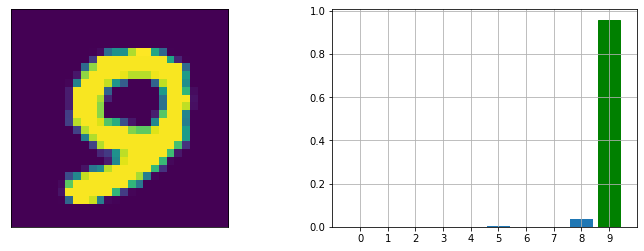

Predicted: 9


In [24]:
import random

idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_digit(sample)

### Pro Pipelines

In [25]:
EPOCHES = 4
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [26]:
class Model(kr.Model):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = kr.layers.Conv2D(32, (5,5), activation='relu', padding='same')
        self.conv2 = kr.layers.Conv2D(64, (5,5), activation='relu', padding='same')
        self.fc1 = kr.layers.Dense(256, activation='relu')
        self.fc2 = kr.layers.Dense(10, activation=None)
        self.max_pool = kr.layers.MaxPooling2D((2,2), (2,2))
        self.flatten = kr.layers.Flatten()
        
    def call(self, inp):
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [27]:
model = Model()

In [37]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [30]:
LRATE = 10**-4

optimizer = kr.optimizers.SGD(LRATE)
# optimizer = kr.optimizers.Adam(LRATE)

writer = tf.summary.create_file_writer('./logs/sgd')
# writer = tf.summary.create_file_writer('./logs/adam')

In [38]:
%%time

for i, (images, labels) in enumerate(train_ds):
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    if i%200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
    print("[%4d] Accuracy: %5.2f %%" % (i, accuracy_value.numpy()*100))
    
    with writer.as_default():
        tf.summary.scalar('accuracy', accuracy_value, i)
        tf.summary.scalar('loss', loss_value, i)

NotFoundError: Could not find valid device for node.
Node:{{node SparseSoftmaxCrossEntropyWithLogits}}
All kernels registered for op SparseSoftmaxCrossEntropyWithLogits :
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT64]
  device='GPU'; T in [DT_FLOAT]; Tlabels in [DT_INT32]
  device='GPU'; T in [DT_FLOAT]; Tlabels in [DT_INT64]
  device='GPU'; T in [DT_HALF]; Tlabels in [DT_INT32]
  device='GPU'; T in [DT_HALF]; Tlabels in [DT_INT64]
 [Op:SparseSoftmaxCrossEntropyWithLogits]